In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

Let's pick and load a pretrained model! 
Or build your own, save as .h5 file, load!

In [2]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')

# pretrained_model = tf.keras.applications.resnet50.ResNet50(include_top=True,
#                                                      weights='imagenet')

# pretrained_model = tf.keras.applications.inception_v3.InceptionV3(include_top=True,
#                                                                   weights='imagenet')

# pretrained_model = tf.keras.applications.nasnet.NASNetMobile(include_top=True,
#                                                              weights='imagenet')

pretrained_model.trainable = False

# ImageNet labels #Decoder is the same for all pretrained imagenet models.
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions 

In [3]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = image/255
    image = image / tf.math.reduce_max(image)
    image = tf.image.resize(image, (224, 224))
    image = image[None, ...]
    return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
    return decode_predictions(probs, top=1)[0][0]

In [40]:
#Upload any image
image_raw = tf.io.read_file("images/2.png") 
image = tf.image.decode_image(image_raw,3)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

Let's have a look at the image.

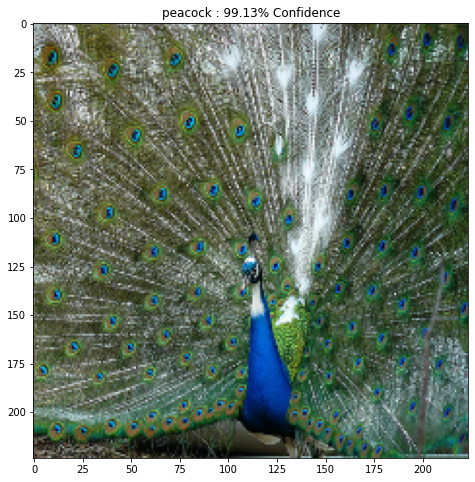

In [41]:
plt.figure()
plt.imshow(image[0])
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

## Create the adversarial image

### Implementing fast gradient sign method
The first step is to create perturbations which will be used to distort the original image resulting in an adversarial image. As mentioned, for this task, the gradients are taken with respect to the image.

In [7]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image) 
        prediction = pretrained_model(input_image)
        loss = loss_object(input_label, prediction)

    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, input_image)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    return signed_grad, gradient 

The resulting perturbations can also be visualised.

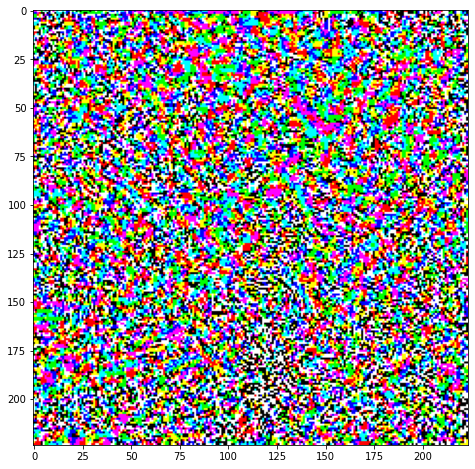

In [21]:
# Get the input label of the image.
labrador_retriever_index = 84
label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations , enhance = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0])

Let's try this out for different values of epsilon and observe the resultant image. You'll notice that as the value of epsilon is increased, it becomes easier to fool the network. However, this comes as a trade-off which results in the perturbations becoming more identifiable.

In [22]:
def display_images(image, description):
  
    _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
    plt.figure()
    plt.imshow(image[0])
    plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
    plt.show()

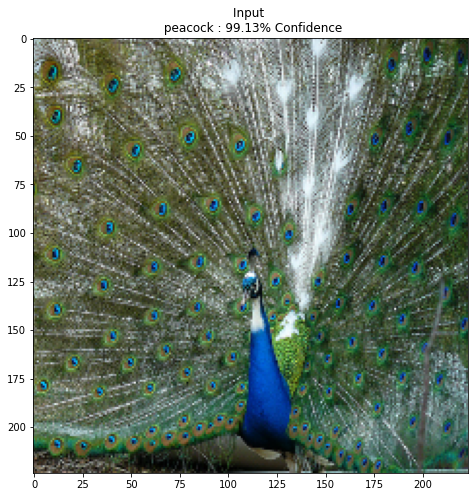

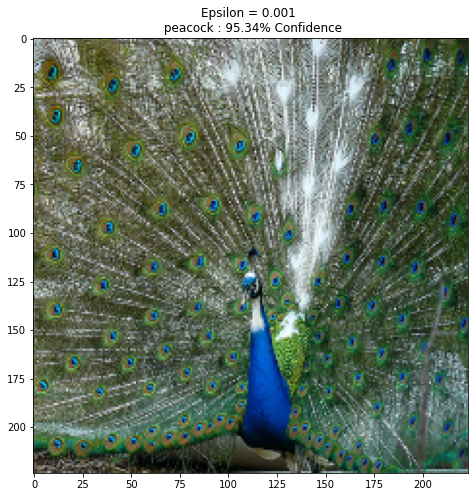

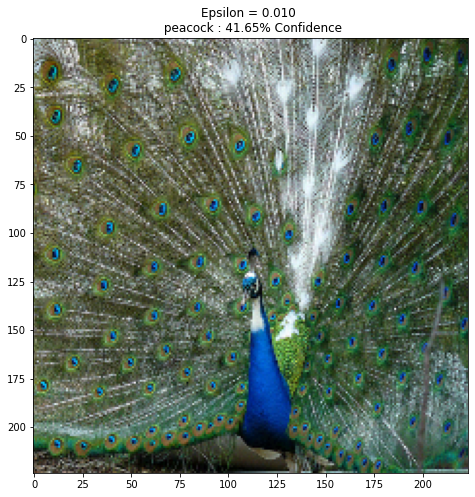

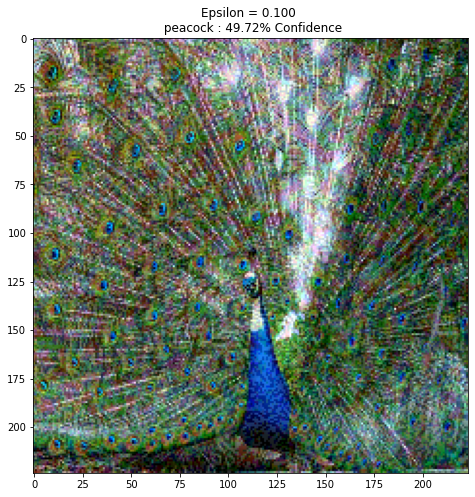

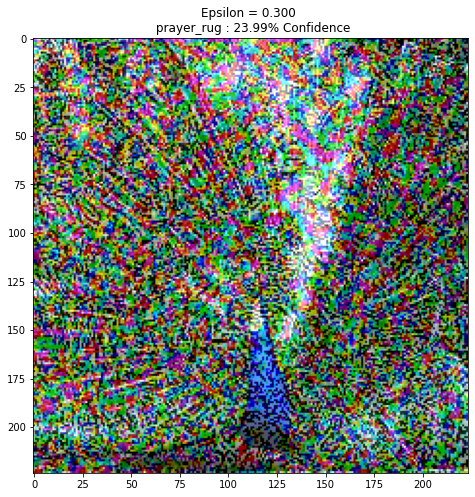

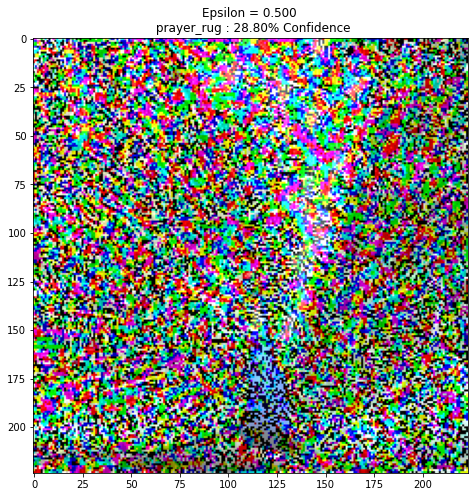

In [25]:
epsilons = [0.3]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
    adv_x = eps*perturbations + image 
    adv_x = tf.clip_by_value(adv_x, 0, 1)
    display_images(adv_x, descriptions[i])

We can look at different intensity of perturbation and what model sees


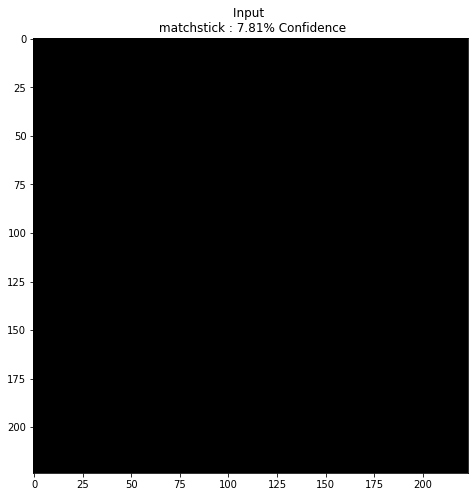

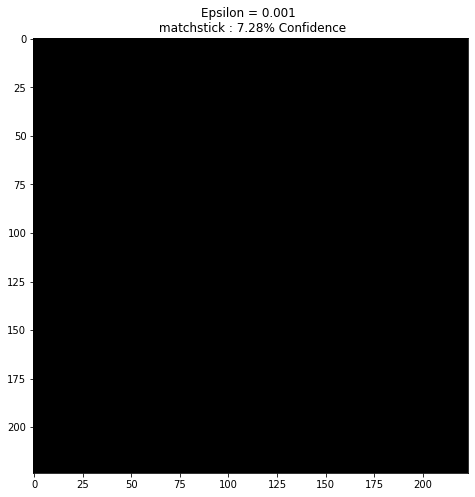

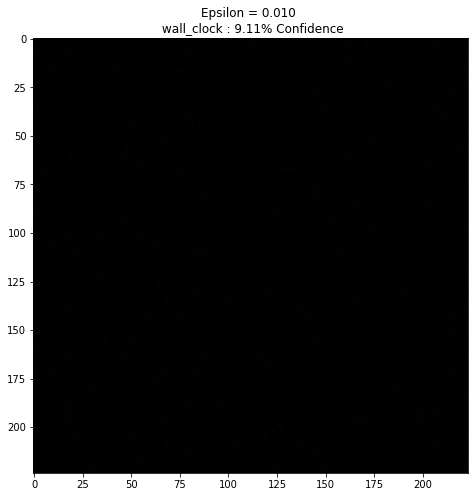

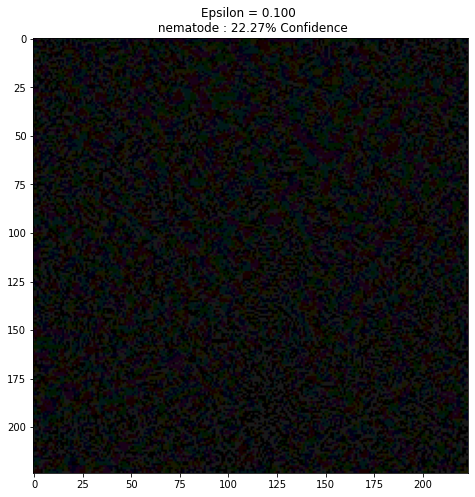

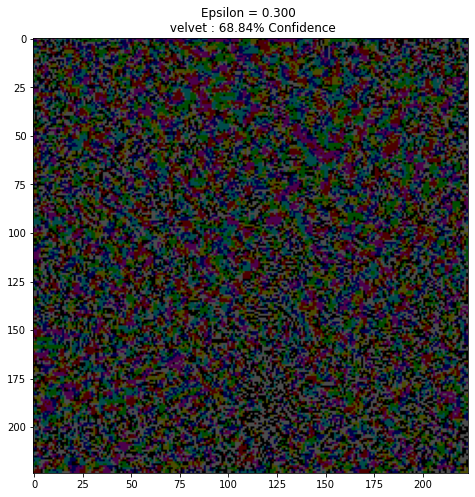

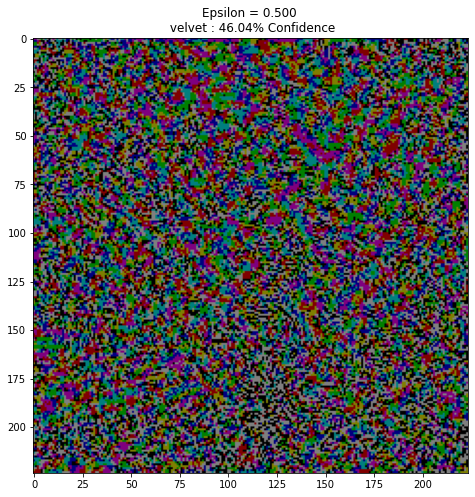

In [26]:
epsilons = [0, 0.001, 0.01,0.1, 0.3,0.5]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
    adv_x = eps*perturbations# + image 
    adv_x = tf.clip_by_value(adv_x, 0, 1)
    display_images(adv_x, descriptions[i])

We can also add different noise level to "enhance" the confidence of model.
However, adding too much will hurt more than help

Note that now the noise added is **negative of gradient**.
This is what we usually do for gradient descend

---



Iterative attack:
First, pick a class index.
Then start the attack!

In [28]:
image_raw = tf.io.read_file("images/2.png")
image = tf.image.decode_image(image_raw,3)

image = preprocess(image)

index = 84 #Find class index here: https://github.com/USCDataScience/dl4j-kerasimport-examples/blob/master/dl4j-import-example/data/imagenet_class_index.json
label = tf.one_hot(index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))
perturbations , enhance = create_adversarial_pattern(image, label)
accumulated = 0*image #accumulate gradients over the iterations

for j in range(20): #Most attacks will start to show result before 100 iterations

    epsilons = [-0.01,-0.05]
    descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                  for eps in epsilons]

    for i, eps in enumerate(epsilons):
        accumulated = eps*enhance + accumulated
        adv_x = eps*enhance + image 
        adv_x = tf.clip_by_value(adv_x, 0, 1)
        # display_images(adv_x, j)
perturbations , enhance = create_adversarial_pattern(image, label)
image = adv_x

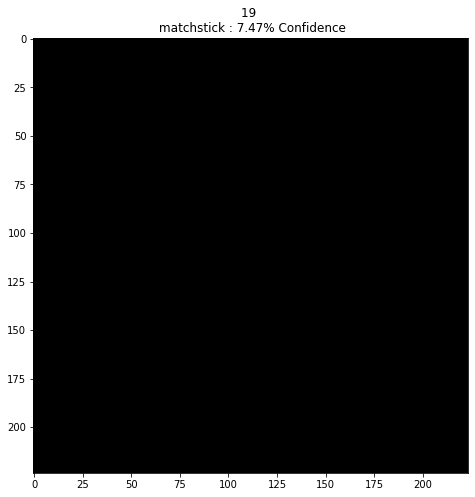

In [29]:
display_images(accumulated, j)

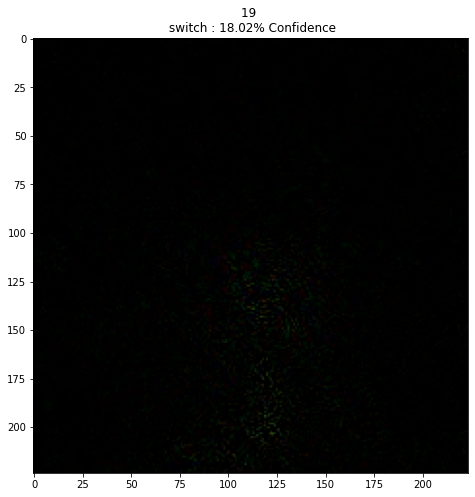

In [30]:
display_images(accumulated*50, j)

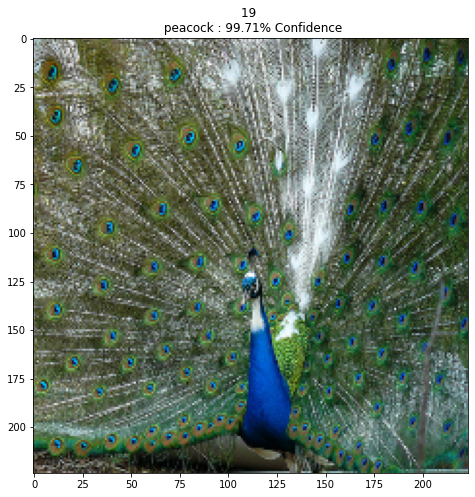

In [31]:
image_raw = tf.io.read_file("images/2.png")
image = tf.image.decode_image(image_raw,3)

image = preprocess(image)
display_images(accumulated*1+image, j)

This approach is not an Universial attack.

Some fast exercises:

1. Try create Universial attack  
2. Test transferability of attack on different models. 
3. Plot and analyze accuracy lost among different models per iteration


